In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
from tqdm import tqdm
import configparser
import pickle

config = configparser.ConfigParser()
config.read("config.ini")

#importing local module 
from models.subclasses import *
from models.utilities import *
from models.train import *
from models.predict import *

In [2]:
# Train sample size (-1 for max) 
# can't exceed 118286 sample
sample = int(config['config']['sample'])

#train split percentage 80-20
percentage = float(config['config']['percentage'])

# Max word count for a caption.
max_length = int(config['config']['max_length'])
# Use the top 5000 words for a vocabulary.
vocabulary_size = int(config['config']['vocabulary_size'])

## Importing data

In [25]:
# create data lists
# import data and save it to a dict, also save it's keys in a list 
train_image_paths, image_path_to_caption = import_files(shuffle= False)

# save data lists 

60000


In [31]:
image_path_to_caption[train_image_paths[0]]

['<start> A bicycle replica with a clock as the front wheel. <end>',
 '<start> The bike has a clock as a tire. <end>',
 '<start> A black metal bicycle with a clock inside the front wheel. <end>',
 '<start> A bicycle figurine in which the front wheel is replaced with a clock\n <end>',
 '<start> A clock with the appearance of the wheel of a bicycle  <end>']

In [ ]:
# load data lists


In [30]:
type(train_image_paths)
type(image_path_to_caption)
# image_path_to_caption[train_image_paths[0]]

collections.defaultdict

## Prepair data

<start> A biker with a helmet on is standing behind two motorcycles. <end>


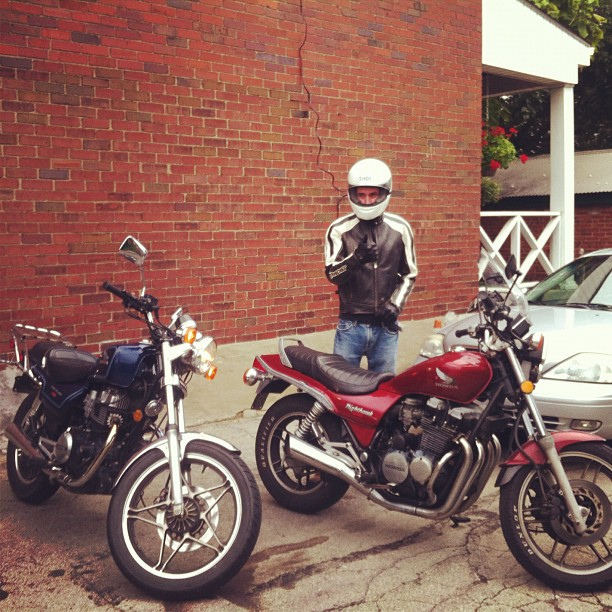

In [4]:
train_captions = []
img_name_vector = []
for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

print(train_captions[0])
Image.open(img_name_vector[0])

## Prepair the models

In [5]:
# create and freeze feature extractor model 
image_features_extract_model = get_features_extractor()

In [8]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img) #Kernal dies here :D
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 1875/1875 [05:55<00:00,  5.27it/s]


In [9]:
word_to_index, index_to_word, tokenizer, cap_vector = tokenization(train_captions, max_length, vocabulary_size)

In [10]:
img_name_train, cap_train, img_name_val, cap_val = split_data(img_name_vector, cap_vector, percentage)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(285139, 285139, 15011, 15011)

In [11]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = int(config['config']['BATCH_SIZE'])
BUFFER_SIZE = int(config['config']['BUFFER_SIZE'])
embedding_dim = int(config['config']['embedding_dim'])
units = int(config['config']['units'])
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = int(config['config']['features_shape'])
attention_features_shape = int(config['config']['attention_features_shape'])

# Training parameters
epochs = int(config['config']['epochs'])
num_steps = len(img_name_train) // BATCH_SIZE

In [12]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
if shuffle:
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Making the models

In [13]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

## Training

In [14]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [15]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
epochs = 200
loss_plot = train(epochs, start_epoch, ckpt_manager, num_steps,
              dataset, decoder, encoder, word_to_index)

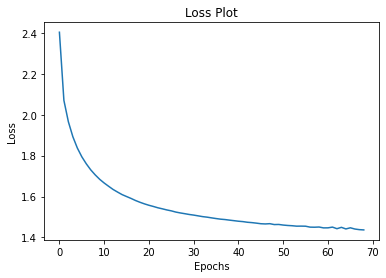

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Result

Real Caption: <start> a police officer on his horse during patrol. <end>
Prediction Caption: a girl seen looking at camera and a set of water. <end>


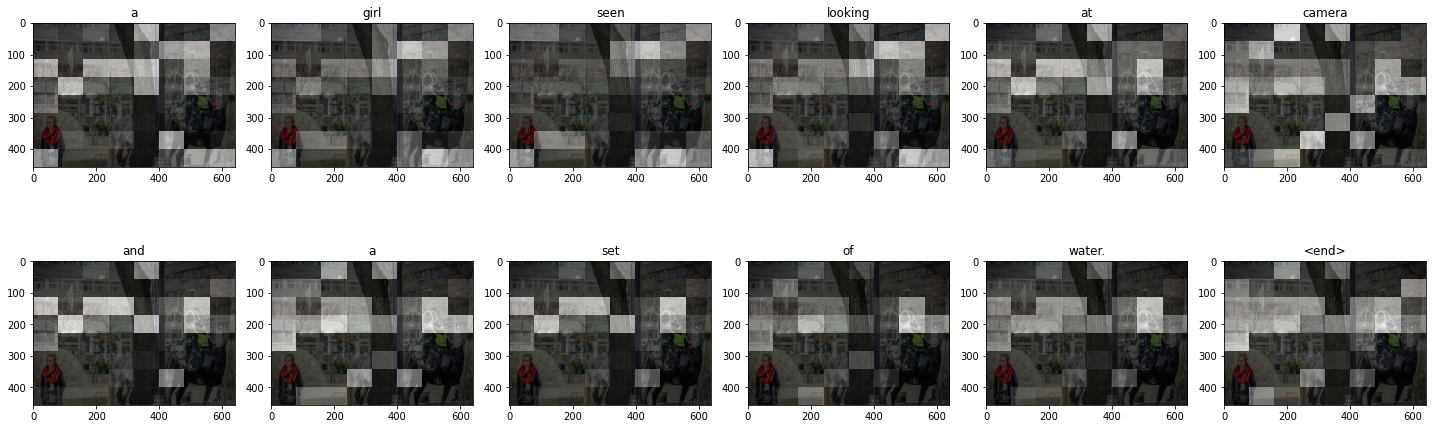

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder, decoder, image_features_extract_model,
                                    word_to_index, index_to_word)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> pedestrians passing a long line of motorcycles on a city street. <end>
Prediction Caption: many motorcycles parked in the city. <end>


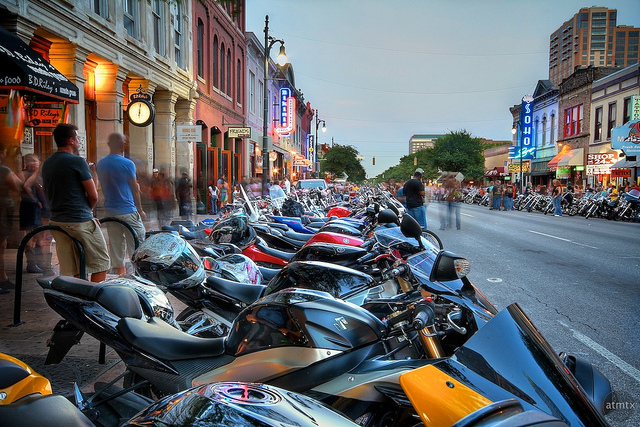

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
                         
result = predict(image, encoder, decoder,
            image_features_extract_model,
            word_to_index, index_to_word)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [ ]:
save_path = 'saves/'

In [ ]:
def save_all(encoder, decoder, image_features_extract_model):

    encoder.save(f"{save_path}encoder2")
    decoder.save(f"{save_path}decoder2")
    image_features_extract_model.save(f"{save_path}features_extract2")

In [ ]:
pickle.dump(encode_train, open(f'{save_path}encode_train2', "wb"))
pickle.dump(train_captions, open(f'{save_path}train_captions2', "wb"))

In [ ]:
save_all(encoder, decoder, image_features_extract_model)

INFO:tensorflow:Assets written to: saves/encoder\assets


INFO:tensorflow:Assets written to: saves/encoder\assets


INFO:tensorflow:Assets written to: saves/decoder\assets


INFO:tensorflow:Assets written to: saves/decoder\assets


INFO:tensorflow:Assets written to: saves/features_extract\assets


INFO:tensorflow:Assets written to: saves/features_extract\assets
C:\Users\hazem\anaconda3\envs\uvapp\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\hazem\anaconda3\envs\uvapp\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
